### Load libraries

In [2]:
import sys
sys.path.append('../../wrapper')
import os
import glob
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy import random
import pandas as pd
from collections import Counter

from scipy import interp
from itertools import cycle
from imblearn.under_sampling import RandomUnderSampler

import sklearn
import sklearn.datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing, pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import xgboost
import mglearn

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, auc
from sklearn.model_selection import train_test_split, cross_val_score
import shap
shap.initjs()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import altair as alt
from vega_datasets import data

In [3]:
random_state=20

### Define functions

In [6]:
def encode_cate_attrs(data, cate_attrs):
    data = encode_edu_attrs(data)
    cate_attrs.remove('education')
    for i in cate_attrs:
        dummies_df = pd.get_dummies(data[i])
        dummies_df = dummies_df.rename(columns=lambda x: i+'_'+str(x))
        data = pd.concat([data,dummies_df],axis=1)
        data = data.drop(i, axis=1)
    return data

def encode_bin_attrs(data, bin_attrs):    
    for i in bin_attrs:
        data.loc[data[i] == 'no', i] = 0
        data.loc[data[i] == 'yes', i] = 1
    return data

def encode_edu_attrs(data):
    values = ["illiterate", "basic.4y", "basic.6y", "basic.9y", 
    "high.school",  "professional.course", "university.degree"]
    levels = range(1,len(values)+1)
    dict_levels = dict(zip(values, levels))
    for v in values:
        data.loc[data['education'] == v, 'education'] = dict_levels[v]
    return data

def fill_unknown(data, bin_attrs, cate_attrs, numeric_attrs):
    fill_attrs = []
    for i in bin_attrs+cate_attrs:
        if data[data[i] == 'unknown']['y'].count() < 500:
            # delete col containing unknown
            data = data[data[i] != 'unknown'] 
        else:
            fill_attrs.append(i)
    data = encode_cate_attrs(data, cate_attrs)
    data = encode_bin_attrs(data, bin_attrs)
    data['y'] = data['y'].map({'no': 0, 'yes': 1}).astype(int)
    for i in fill_attrs:     
        test_data = data[data[i] == 'unknown']
        testX = test_data.drop(fill_attrs, axis=1)
        train_data = data[data[i] != 'unknown']        
        trainY = train_data[i]
        trainX = train_data.drop(fill_attrs, axis=1)
        test_data[i] = train_predict_unknown(trainX, trainY, testX)
        data = pd.concat([train_data, test_data]) 
    return data

def train_predict_unknown(trainX, trainY, testX):
    forest = RandomForestClassifier(n_estimators=100, random_state=random_state)
    trainY=trainY.astype('int')
    forest = forest.fit(trainX, trainY)
    test_predictY = forest.predict(testX).astype(int)
    return pd.DataFrame(test_predictY,index=testX.index)
      
def preprocess_data():
    input_data_path = "/Users/lillian/Documents/graduation_project/datasets/bank-additional/bank-additional-full.csv"
    processed_data_path = '/Users/lillian/Documents/graduation_project/datasets/bank-additional/test.csv'
    print("Loading data...")
    data = pd.read_csv(input_data_path, sep=';')
    print("Preprocessing data...")
    numeric_attrs = ['age', 'duration', 'campaign', 'pdays', 'previous',
                     'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                     'euribor3m', 'nr.employed',]
    bin_attrs = ['default', 'housing', 'loan']
    cate_attrs = ['poutcome', 'education', 'job', 'marital', 
                  'contact', 'month','day_of_week']
    data = shuffle(data, random_state=random_state)
    print(data.shape)
    data = fill_unknown(data, bin_attrs, cate_attrs, numeric_attrs)
    data.to_csv(processed_data_path, index=False)

In [7]:
def k_fold_cross_validation(X_trainval, y_trainval, params, K, randomise = False):
    X = X_trainval.index
    if randomise:    
        np.random.permutation(X)
    
    scores_training = []
    scores_valid = []
    for k in np.arange(K):
        # shuffle split
        train = [x for i, x in enumerate(X) if i % K != k]
        valid = [x for i, x in enumerate(X) if i % K == k]
        X_train = X_trainval.loc[train]
        y_train = y_trainval.loc[train]
        X_valid = X_trainval.loc[valid]
        y_valid = y_trainval.loc[valid]
        # undersampling on training set
        X_train_sampled, y_train_sampled = undersampling(X_train, y_train, 
                                                 RandomUnderSampler(random_state=48), 30)
        X_train_sampled = pd.DataFrame(X_train_sampled, columns=list(X_train))
        # train XGBoost model
        xgb_train = xgboost.DMatrix(X_train_sampled, label=y_train_sampled)
        xgb_valid = xgboost.DMatrix(X_valid, label=y_valid)
        
        xgb = xgboost.train(params, xgb_train, 100)
        xgb_pred_valid = xgb.predict(xgb_valid)
        scores_training.append(roc_auc_score(y_train_sampled, xgb.predict(xgb_train)))
        scores_valid.append(roc_auc_score(y_valid, xgb.predict(xgb_valid)))
    print("AUC score on training set: {:.3f}".format(np.mean(scores_training)))
    print("AUC score on valid set: {:.3f}".format(np.mean(scores_valid)))
    return np.mean(scores_valid)

In [8]:
def undersampling(X, y, sampler, r):
    C = Counter(np.array(y))
    second_class = C.most_common(2)[-1][1]
    major_class = C.most_common(1)[-1][1]
    
    ratio={0: second_class*r}
    print(C)
    uds = sampler
    uds.set_params(ratio=ratio, random_state=random_state)
    X_sampled, y_sampled = uds.fit_sample(X, y)
    print('X_resampled.shape: {}, y_resampled: {}'.format(X_sampled.shape, y_sampled.shape))
    print('y_resample:\n{}'.format(pd.Series(y_sampled).value_counts()))   
    return X_sampled, y_sampled

In [9]:
def combine_categorical_SHAP(df_test):
    df_test['contact'] = df_test['contact_cellular'] + df_test['contact_telephone']
    df_test['day_of_week'] = df_test['day_of_week_mon'] + df_test['day_of_week_tue'] + df_test['day_of_week_wed'] +df_test['day_of_week_thu'] + df_test['day_of_week_fri']
    df_test['job'] = df_test['job_admin.'] + df_test['job_blue-collar'] + df_test['job_entrepreneur'] + df_test['job_housemaid'] + df_test['job_management'] + df_test['job_retired']+ df_test['job_self-employed']+ df_test['job_services']+ df_test['job_student']+ df_test['job_technician'] + df_test['job_technician'] + df_test['job_unemployed']
    df_test['marital'] = df_test['marital_divorced'] + df_test['marital_married'] + df_test['marital_single']
    df_test['month'] = df_test['month_mar'] + df_test['month_apr'] + df_test['month_may'] +df_test['month_jun'] + df_test['month_jul'] + df_test['month_aug'] + df_test['month_sep'] + df_test['month_oct'] + df_test['month_nov'] + df_test['month_dec']
    df_test['poutcome'] = df_test['poutcome_failure'] + df_test['poutcome_success'] + df_test['poutcome_nonexistent']
    drop_attr = ['contact_cellular', 'contact_telephone', 'day_of_week_mon', 'day_of_week_tue', 'day_of_week_wed', 'day_of_week_thu', 'day_of_week_fri', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'month_mar', 'month_apr', 'month_may', 'month_jun', 'month_jul', 'month_aug', 'month_sep', 'month_oct', 'month_nov', 'month_dec', 'poutcome_failure', 'poutcome_success', 'poutcome_nonexistent']
    df_test = df_test.drop(drop_attr, axis=1)
    return df_test

In [10]:
def join_X_shap(df_shap, X_value, y_value, xgb_pred, xgb_pred_text):
    df_shap.columns = [str(col) + '_SHAP' for col in df_shap.columns]
    df_X_shap = X_value.reset_index(drop=True).join(df_shap)
    tmp2 = df_X_shap.join(pd.DataFrame(y_value, columns=['y']).reset_index(drop=True))
    tmp3 = tmp2.join(pd.DataFrame(xgb_pred.astype(int), columns=['predict_num']))
    tmp4 = tmp3.join(pd.DataFrame(xgb_pred_text.astype(str), columns=['predict']))
    tmp4.head()
    return tmp4

In [11]:
def append_conditions(tmp_df, xgb_prob_test):
    tmp_df['prob'] = xgb_prob_test
    tmp_df['condition'] = 'condition'
    tmp_df['condition'].loc[((tmp_df['y']==1) & (tmp_df['predict_num']==1))] = 'TP'
    tmp_df['condition'].loc[((tmp_df['y']==0) & (tmp_df['predict_num']==1))] = 'FP'
    tmp_df['condition'].loc[((tmp_df['y']==1) & (tmp_df['predict_num']==0))] = 'FN'
    tmp_df['condition'].loc[((tmp_df['y']==0) & (tmp_df['predict_num']==0))] = 'TN'
    tmp_df['condition_num'] = 'condition'
    tmp_df['condition_num'].loc[((tmp_df['y']==1) & (tmp_df['predict_num']==1))] = 1 #'TP'
    tmp_df['condition_num'].loc[((tmp_df['y']==0) & (tmp_df['predict_num']==1))] = 0 #'FP'   
    tmp_df['condition_num'].loc[((tmp_df['y']==1) & (tmp_df['predict_num']==0))] = 2 #'FN' 
    tmp_df['condition_num'].loc[((tmp_df['y']==0) & (tmp_df['predict_num']==0))] = 3 #'TN' 
    tmp_pos = tmp_df[(tmp_df['condition_num']==1) | (tmp_df['condition_num']==0)]
    return tmp_df, tmp_pos

### Preprocess bank marketing data

The pre-process including:
- dummy categorical attributes
- convert "education" levels into integer
- predict missing values with a Random Forests model

In [13]:
preprocess_data()

Loading data...
Preprocessing data...
(41188, 21)


In [27]:
raw = pd.read_csv("/Users/lillian/Documents/graduation_project/datasets/bank-additional/bank-additional-full.csv", sep=';')
data = pd.read_csv("/Users/lillian/Documents/graduation_project/datasets/bank-additional/test.csv", sep = ",")

In [28]:
data.loc[data['pdays'] == 999, 'pdays'] = -99
data.describe()

age     education       default       housing          loan  \
count  40787.000000  40787.000000  40787.000000  40787.000000  40787.000000   
mean      39.978817      5.155295      0.000098      0.537328      0.151887   
std       10.402157      1.639345      0.009903      0.498611      0.358915   
min       17.000000      1.000000      0.000000      0.000000      0.000000   
25%       32.000000      4.000000      0.000000      0.000000      0.000000   
50%       38.000000      5.000000      0.000000      1.000000      0.000000   
75%       47.000000      7.000000      0.000000      1.000000      0.000000   
max       98.000000      7.000000      1.000000      1.000000      1.000000   

           duration      campaign         pdays      previous  emp.var.rate  \
count  40787.000000  40787.000000  40787.000000  40787.000000  40787.000000   
mean     258.329811      2.566112    -95.163263      0.172874      0.080516   
std      259.269596      2.768103     19.717559      0.494863      1.570133   
min        0.000000      1.000000    -99.000000      0.000000     -3.400000   
25%      102.000000      1.000000    -99.000000      0.000000     -1.800000   
50%      180.000000      2.000000    -99.000000      0.000000      1.100000   
75%      319.500000      3.000000    -99.000000      0.000000      1.400000   
max     4918.000000     56.000000     27.000000      7.000000      1.400000   

            ...            month_mar     month_may     month_nov  \
count       ...         40787.000000  40787.000000  40787.000000   
mean        ...             0.013264      0.333905      0.100203   
std         ...             0.114405      0.471612      0.300275   
min         ...             0.000000      0.000000      0.000000   
25%         ...             0.000000      0.000000      0.000000   
50%         ...             0.000000      0.000000      0.000000   
75%         ...             0.000000      1.000000      0.000000   
max         ...             1.000000      1.000000      1.000000   

          month_oct     month_sep  day_of_week_fri  day_of_week_mon  \
count  40787.000000  40787.000000     40787.000000     40787.000000   
mean       0.017334      0.013779         0.190723         0.206438   
std        0.130514      0.116573         0.392876         0.404754   
min        0.000000      0.000000         0.000000         0.000000   
25%        0.000000      0.000000         0.000000         0.000000   
50%        0.000000      0.000000         0.000000         0.000000   
75%        0.000000      0.000000         0.000000         0.000000   
max        1.000000      1.000000         1.000000         1.000000   

       day_of_week_thu  day_of_week_tue  day_of_week_wed  
count     40787.000000     40787.000000     40787.000000  
mean          0.209135         0.196288         0.197416  
std           0.406696         0.397194         0.398054  
min           0.000000         0.000000         0.000000  
25%           0.000000         0.000000         0.000000  
50%           0.000000         0.000000         0.000000  
75%           0.000000         0.000000         0.000000  
max           1.000000         1.000000         1.000000  

[8 rows x 49 columns]

### Drop unrelated columns

In [29]:
data_category = raw[['contact', 'day_of_week', 'job', 'marital', 'month', 'poutcome']]
data = data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'nr.employed', 'cons.conf.idx'], axis=1)
data.shape

(40787, 44)

In [30]:
X = data.drop(['y'], axis=1)
y = data.y

### Split data into train/val/test with ratio 60/20/20

The data are stratified split into the training, validation and test sets; 60% is used as the training
set, 20% is used for validating the parameters and 20% is used as the testing set for evaluating
model performance.

In [31]:
X_trainval, X_test, y_trainval, y_test=train_test_split(X, y, test_size = 0.2, stratify = y, random_state = random_state)
X_train, X_valid, y_train, y_valid=train_test_split(X_trainval, y_trainval, test_size = 0.2, stratify = y_trainval, random_state = random_state)

### Under-sampling

To deal with class imbalance, I applied Random under-sampling on the training set to
balance two classes into an equal sample size.

In [32]:
X_trainval_sampled, y_trainval_sampled = undersampling(X_trainval, y_trainval, 
                                                 RandomUnderSampler(random_state=random_state), 1)
X_trainval_sampled = pd.DataFrame(X_trainval_sampled, columns=list(X_trainval))

Counter({0: 28954, 1: 3675})
X_resampled.shape: (7350, 43), y_resampled: (7350,)
y_resample:
1    3675
0    3675
dtype: int64


### Build XGBoost model

In [33]:
xgb_trainval = xgboost.DMatrix(X_trainval_sampled, label=y_trainval_sampled)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

params = {'max_depth':3, 'n_estimators':100,
          'objective': "binary:logistic",
          'early_stopping_rounds':10, 
          'gamma': 0.9, 
          'learning_rate': 0.1,
          "base_score": np.mean(y_trainval_sampled),
          "eval_metric": "logloss",
          "silent":1}

xgb = xgboost.train(params, xgb_trainval, 100)
xgb_pred_test = np.where(xgb.predict(xgb_test)>0.5, 1, 0)
xgb_pred_text_test = np.where(xgb.predict(xgb_test)>0.5, 'Yes', 'No')
xgb_prob_test = xgb.predict(xgb_test)

In [34]:
print("AUC score on training set: {:.3f}".format(roc_auc_score(y_trainval_sampled, xgb.predict(xgb_trainval))))
print("AUC score on test set: {:.3f}".format(roc_auc_score(y_test, xgb.predict(xgb_test))))

confusion_matrix(y_test, xgb_pred_test)

AUC score on training set: 0.817
AUC score on test set: 0.810


array([[6113, 1126],
       [ 311,  608]])

### Comupted SHAP explanation values

In [35]:
explainer = shap.TreeExplainer(xgb)
shap_xgb_trainval = explainer.shap_values(X_trainval_sampled)
shap_xgb_test = explainer.shap_values(X_test)

As the categorical attributes are converted into dummy attributes, the SHAP value of the categorical attributes is the sum of the SHAP values from all
categories.

In [36]:
df_shap_test = pd.DataFrame(shap_xgb_test , columns = list(X_test))
df_shap_test = combine_categorical_SHAP(df_shap_test)

In [37]:
drop_attr = ['contact_cellular', 'contact_telephone', 'day_of_week_mon', 'day_of_week_tue', 'day_of_week_wed', 'day_of_week_thu', 'day_of_week_fri', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'month_mar', 'month_apr', 'month_may', 'month_jun', 'month_jul', 'month_aug', 'month_sep', 'month_oct', 'month_nov', 'month_dec', 'poutcome_failure', 'poutcome_success', 'poutcome_nonexistent']
X_test_cat = X_test.drop(drop_attr, axis=1)
X_test_cat = X_test_cat.join(data_category)
tmp_test = join_X_shap(df_shap_test, X_test_cat, y_test, xgb_pred_test, xgb_pred_text_test)
df_test, df_test_pos = append_conditions(tmp_test, xgb_prob_test)

In [38]:
X_cat = X.drop(drop_attr, axis=1)
X_cat = X_cat.join(data_category)

In [39]:
X_cat.head()

age  education  default  housing  loan  campaign  pdays  previous  \
0   33          7        0        1     1         4    -99         0   
1   36          5        0        1     1         1    -99         0   
2   35          6        0        0     0         8    -99         0   
3   51          7        0        0     0         6    -99         1   
4   31          5        0        1     1         1    -99         0   

   euribor3m    contact day_of_week        job  marital month     poutcome  
0      1.281  telephone         mon  housemaid  married   may  nonexistent  
1      4.856  telephone         mon   services  married   may  nonexistent  
2      4.859  telephone         mon   services  married   may  nonexistent  
3      4.076  telephone         mon     admin.  married   may  nonexistent  
4      4.963  telephone         mon   services  married   may  nonexistent

In [40]:
n_feature = X_test_cat.shape[1]

### Barchart of the most important features

This plot shows the feature importance computed by the mean of the absolute SHAP values. In this case, the most important features are: 
- "euribor3m"- euribor three month rate, which is a social and economic context 
- "month"- last contact month of the current campaign of year
- "contact"- contact communication type

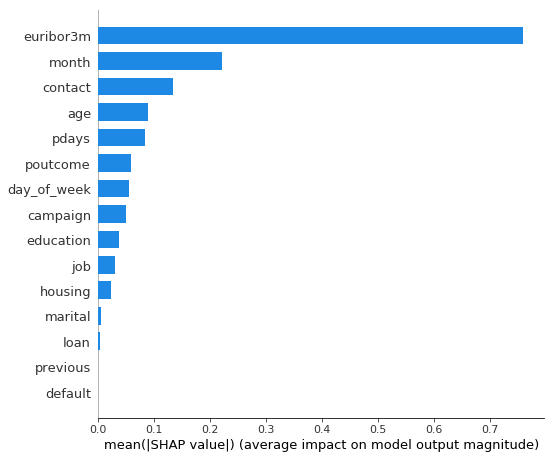

In [27]:
shap.summary_plot(df_test.iloc[:, n_feature:n_feature+n_feature], df_test.iloc[:, 0:n_feature], plot_type="bar")

### Scatter plot between feature values and the SHAP values

This plot can be used to identify which feature values have a higher contribution to the target class and derive general explanations. For example, the value of "euribor3m" is lower than 2 has a higher probability of being classiffied as "yes". The generality can easily be measured by computing the support of the
feature.

(array([  0.,   2.,   1.,   0.,   4.,  15.,  16.,  14., 352.,  66., 103.,
        290., 131., 113., 292., 197.,  71.,  37.,  18.,  12.]),
 array([-1.32229483, -1.13456269, -0.94683055, -0.7590984 , -0.57136626,
        -0.38363412, -0.19590198, -0.00816984,  0.17956231,  0.36729445,
         0.55502659,  0.74275873,  0.93049088,  1.11822302,  1.30595516,
         1.4936873 ,  1.68141944,  1.86915159,  2.05688373,  2.24461587,
         2.43234801]),
 <a list of 20 Patch objects>)

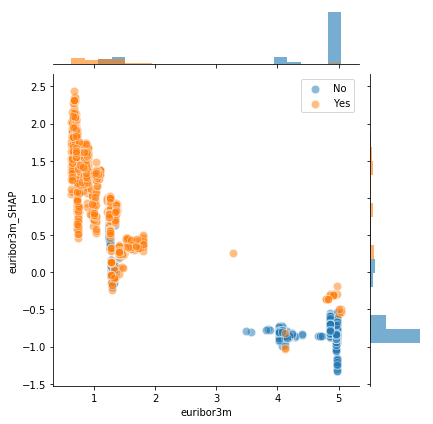

In [45]:
feature = 'euribor3m'

cate_attrs = ['poutcome', 'education', 'job', 'marital', 
              'contact', 'month','day_of_week']
if feature1 in cate_attrs:
    le = preprocessing.LabelEncoder()
    le.fit(df_test[df_test['predict_num']==0][feature1])
    cat_neg = le.transform(df_test[df_test['predict_num']==0][feature1])
    cat_pos = le.transform(df_test[df_test['predict_num']==1][feature1])

kws = dict(s=70, linewidth=.7, edgecolor="w", alpha=0.5)

p = seaborn.JointGrid(
    x = df_test[df_test['predict_num']==0][feature],
    y = df_test[df_test['predict_num']==0][feature+"_SHAP"])

p = p.plot_joint(
    plt.scatter, **kws, label='No'
    )
p.x = df_test[df_test['predict_num']==1][feature]
p.y = df_test[df_test['predict_num']==1][feature+"_SHAP"]
p.plot_joint(plt.scatter, marker='o',  **kws, label='Yes')

plt.legend()

if feature1 in cate_attrs:
    print(np.min(cat_neg), np.max(cat_neg))
    p.ax_marg_x.hist(
        cat_neg,
        alpha = 0.6,
        bins=20,
        range = (np.min(cat_neg), np.max(cat_neg))
        )
    p.ax_marg_x.hist(
        cat_pos,
        alpha = 0.6,
        bins=20,
        range = (np.min(cat_neg), np.max(cat_neg))
        )
else:
    
    p.ax_marg_x.hist(
        df_test[df_test['predict_num']==0][feature1],
        alpha = 0.6,
        bins=20,
        range = (np.min(df_test[feature1]), np.max(df_test[feature1]))
        )


    p.ax_marg_x.hist(
        df_test[df_test['predict_num']==1][feature1],
        alpha = 0.6,
        bins=20,
        range = (np.min(df_test[feature1]), np.max(df_test[feature1]))
        )

p.ax_marg_y.hist(
    df_test[df_test['predict_num']==0][feature2],
    orientation = 'horizontal',
    alpha = 0.6,
    bins=20,
    range = (np.min(df_test[feature2]), np.max(df_test[feature2]))
    )


p.ax_marg_y.hist(
    df_test[df_test['predict_num']==1][feature2],
    orientation = 'horizontal',
    alpha = 0.6,
    bins=20,
    range = (np.min(df_test[feature2]), np.max(df_test[feature2]))
)

### Boxplot of the SHAP values

Abnormal causes can be related to some features with infrequent values but have a strong influence on the prediction.
The unusual values can be captured in the boxplot. The plot shows that *"age", "campaign", "pdays", "euribor3m"* and *"month"* have some outliers with higher SHAP values.

Text(0,0.5,'SHAP values')

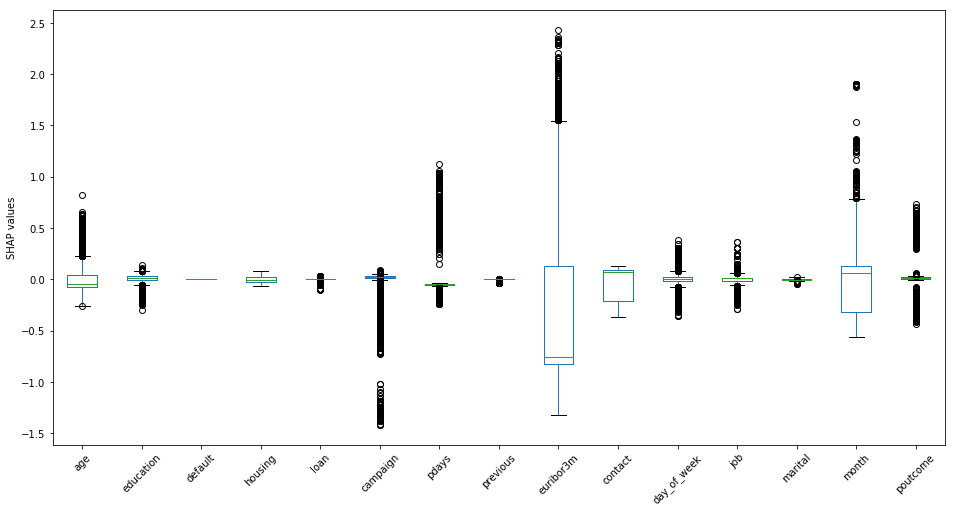

In [32]:
ax = df_test.iloc[:, n_feature:n_feature+n_feature].plot.box(figsize=(16,8))
plt.xticks(np.arange(1, n_feature+1), list(df_test.iloc[:, 0:n_feature]), rotation=45)
ax.set_ylabel('SHAP values')

### Interactive scatter plot of two variables

We can select a different group of instances by moving the grey rectangular selector.
For example, if we changing the age from range 30-40 to range 20-30, we can immediately identify if
the probability of predicting *"yes"* is increased. Also, we can find that the education level has a higher impact on
customers' age between 20 and 30 than the customers' age between 30 and 40.

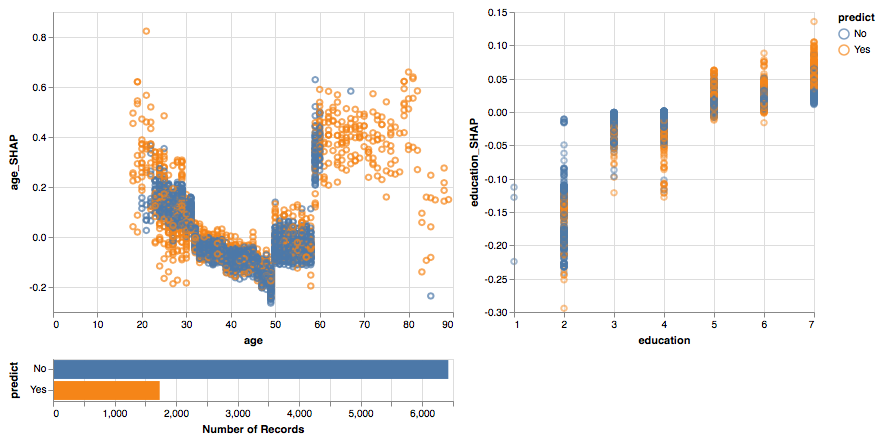

In [46]:
feature1 = "age"
feature2 = "education"

####
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')
alt.themes.enable('opaque')

brush = alt.selection(type='interval')
palette = alt.Scale(domain=[0.0, 1.0],
                  range=["blue", "amber"])

points = alt.Chart().mark_point().encode(
    x=feature1,
    y=feature1+'_SHAP',
    color=alt.condition(brush, 'predict:N', alt.value('lightgrey'))
).add_selection(
    brush
)

bars = alt.Chart().mark_bar().encode(
    y='predict:N',
    color='predict:N',
    x='count(predict):Q'
).transform_filter(
    brush
)

base2 = alt.Chart(df_test).mark_point(opacity=0.5).encode(
     y = feature2+'_SHAP',
    color=alt.condition(brush, 'predict', alt.ColorValue('#D3D3D300')),#
).add_selection(
    brush
).properties(
    width=300,
    height=300
)

alt.vconcat(points, bars, data=df_test) | base2.encode(alt.X(feature2, scale=alt.Scale(zero=False )))

### Plot the SHAP values for all the instances

We can further plot the SHAP values for all the instances and find the cluster within each group.

In [29]:
subgroup = df_test[(df_test['age']>20) & (df_test['age']<30)]
subsamples = subgroup.sample(frac=1, replace=True)
shap.force_plot(explainer.expected_value, np.array(subsamples.iloc[:, n_feature:n_feature+n_feature]), subsamples.iloc[:, 0:n_feature])

In [30]:
subgroup = df_test[(df_test['age']>30) & (df_test['age']<40)]
subsamples = subgroup.sample(frac=1, replace=True)
shap.force_plot(explainer.expected_value, np.array(subsamples.iloc[:, n_feature:n_feature+n_feature]), subsamples.iloc[:, 0:n_feature])